### Notes

  - General Version.
  
  #### V2.0
  - Adding LostDemand in gap definition

In [1]:
# Production Code

import lore.io
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import math

medley in development on jianhuitian@Jianhui-C02XD23FJGH5 with Python 3.6.4 & Lore 0.8.4


/Users/jianhuitian/.pyenv/versions/3.6.4/envs/medley/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)
/Users/jianhuitian/.pyenv/versions/3.6.4/envs/medley/lib/python3.6/site-packages/pandas/plotting/_converter.py:284: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0E9)
/Users/jianhuitian/.pyenv/versions/3.6.4/envs/medley/lib/python3.6/site-packages/pandas/plotting/_converter.py:284: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0E9)
/Users/jianhuitian/.pyenv/versions/3.6.4/envs/medley

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

### Notes

  - SF (1) had change for having batches
  - West LA (972) looks good for candidate zone. 

In [3]:
# Production Code

z_id = 972
end_dt = datetime(2020, 7, 27)
end_dt_str = str(end_dt.date())
days = 56

df = lore.io.snowflake.dataframe("""
select od.order_id
, od.user_id
, od.zone_id
, od.warehouse_id
, od.warehouse_location_id
, od.delivery_type
, od.created_at as created_at_utc
, convert_timezone('UTC', z.time_zone_name, od.created_at) as created_at
, convert_timezone('UTC', z.time_zone_name, od.window_ends_at) as window_ends_at
, convert_timezone('UTC', z.time_zone_name, od.delivered_at) as delivered_at
from order_deliveries od
join zones z on z.id = od.zone_id
where zone_id = %(zone_id)s
and od.workflow_state <> 'canceled'
and convert_timezone('UTC', z.time_zone_name, od.window_ends_at) >= %(date)s::date - %(days)s
and convert_timezone('UTC', z.time_zone_name, od.window_ends_at) < %(date)s
""", zone_id=z_id, date=end_dt_str, days=days)

df_capacity = lore.io.snowflake.dataframe("""
with prep as (
SELECT
    td.created_at as created_at_utc,
    convert_timezone('UTC', z.time_zone_name, td.created_at) as created_at,
    case when parse_json(data)['capacity_on']::varchar = 'true' then 1 else 0 end as capacity_on
FROM true_demand td
join zones z on z.id = td.zone_id
where td.zone_id = %(zone_id)s
and local_date >= %(date)s::date - %(days)s
and local_date < %(date)s
and demand_type = 'v4_medley_test'
)

select
    created_at,
    created_at_utc,
    capacity_on
from prep
order by 1
""", zone_id =z_id, date=end_dt_str, days=days)

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...


In [4]:
df.head(3)

,order_id,user_id,zone_id,warehouse_id,warehouse_location_id,delivery_type,created_at_utc,created_at,window_ends_at,delivered_at
0,401558894,102967963,972,38,333.0,two_hour,2020-06-08 16:34:31.504537,2020-06-08 09:34:31.504537,2020-06-08 11:34:30.955564,2020-06-08 10:32:46.251
1,401413908,52705281,972,5,319.0,asap,2020-06-08 05:59:30.497902,2020-06-07 22:59:30.497902,2020-06-09 13:00:00.000000,2020-06-08 10:34:30.348
2,400917889,55360046,972,38,333.0,limited_availability,2020-06-07 05:44:43.864674,2020-06-06 22:44:43.864674,2020-06-08 13:00:00.000000,2020-06-08 10:37:09.243


In [5]:
df_capacity.tail(3)

,created_at,created_at_utc,capacity_on
39984,2020-07-26 23:55:27.980061,2020-07-27 06:55:27.980061,1
39985,2020-07-26 23:57:28.082337,2020-07-27 06:57:28.082337,1
39986,2020-07-26 23:59:31.942956,2020-07-27 06:59:31.942956,1


In [6]:
# Production Code

df_shoppers = lore.io.snowflake.dataframe("""
select date_trunc('minute', br.snapshot_at) as snapshot_at_utc,
date_trunc('minute', convert_timezone('UTC', z.time_zone_name, br.snapshot_at)) as created_at,
parse_json(br.metrics)['num_eligible_no_shift_shoppers']::numeric eligible_shoppers, 
parse_json(br.metrics)['on_demand_shoppers_work_summary']['num_working_on_demand_shoppers']::numeric
        as working_shoppers,
parse_json(metrics)['num_unique_on_demand_shoppers_have_batches']::numeric as shoppers_having_batches
from batching_runs br
join zones z on z.id = br.zone_id
where convert_timezone('UTC', z.time_zone_name, snapshot_at)::date >= %(date)s::date - %(days)s
and convert_timezone('UTC', z.time_zone_name, snapshot_at)::date < %(date)s::date
and br.zone_id = %(zone_id)s
and br.run_type = 'matching'
and br.simulation_id is null
order by 1
""", zone_id=z_id, date=end_dt_str, days=days)

In [7]:
# Production Code
# Get Lost Demands

df_lost = lore.io.snowflake.dataframe("""
With demands as (
select * from demand_levels
where zone_id = %(zone_id)s
and date >= %(date)s::date - %(days)s
and date < %(date)s::date
),

lost_demands as (
select zone_id, date, hour, sum(value) as hourly_ld from demand_estimates
where zone_id = %(zone_id)s
and date >= %(date)s::date - %(days)s
and date < %(date)s::date
group by 1, 2, 3
order by 1, 2, 3
)

select d.zone_id
, d.date
, ld.hour
, dateadd(hour, ld.hour, d.date) as created_at
, d.lost_deliveries as daily_ld
, d.deliveries
, round(d.demand, 2) as demand
, round(ld.hourly_ld, 2) as hourly_ld
from demands d
join lost_demands ld on d.zone_id = ld.zone_id and d.date = ld.date
order by 1, 2, 3""", zone_id=z_id, date=end_dt_str, days=days)

# Get hourly lost demand percent

df_lost['ld_percent'] = df_lost['hourly_ld'] / df_lost['demand']

In [8]:
df_lost.head(5)

,zone_id,date,hour,created_at,daily_ld,deliveries,demand,hourly_ld,ld_percent
0,972,2020-06-01,0,2020-06-01 00:00:00,1645,3064,4709.43,13.49,0.002864
1,972,2020-06-01,1,2020-06-01 01:00:00,1645,3064,4709.43,7.41,0.001573
2,972,2020-06-01,2,2020-06-01 02:00:00,1645,3064,4709.43,7.39,0.001569
3,972,2020-06-01,3,2020-06-01 03:00:00,1645,3064,4709.43,5.04,0.001070
4,972,2020-06-01,4,2020-06-01 04:00:00,1645,3064,4709.43,4.44,0.000943


In [9]:
df_shoppers.tail(3)

,snapshot_at_utc,created_at,eligible_shoppers,working_shoppers,shoppers_having_batches
43920,2020-07-27 06:58:00,2020-07-26 23:58:00,3600.0,2.0,NaN
43921,2020-07-27 06:59:00,2020-07-26 23:59:00,3600.0,2.0,NaN
43922,2020-07-27 06:59:00,2020-07-26 23:59:00,1000.0,0.0,NaN


### Feature Engineering

In [10]:
# Production Code

# Convert to string then back to datetime to avoid wired timezone bug.
# Convert to string
df_shoppers['created_at'] = df_shoppers['created_at'].map(lambda x: str(x)[:19])
df_capacity['created_at'] = df_capacity['created_at'].map(lambda x: str(x)[:19])
df['created_at'] = df['created_at'].map(lambda x: str(x)[:19])
df['window_ends_at'] = df['window_ends_at'].map(lambda x: str(x)[:19])
df['delivered_at'] = df['delivered_at'].map(lambda x: str(x)[:19])
df_lost['created_at'] = df_lost['created_at'].map(lambda x: str(x)[:19])

# Convert to datetime
df_capacity['created_at'] = pd.to_datetime(df_capacity['created_at'], infer_datetime_format=True)
df_shoppers['created_at'] = pd.to_datetime(df_shoppers['created_at'], infer_datetime_format=True)
df_lost['created_at'] = pd.to_datetime(df_lost['created_at'], infer_datetime_format=True)
df_shoppers.dropna(subset=['eligible_shoppers'], inplace=True)
df_shoppers.fillna(0, inplace=True)
for _col in ['created_at', 'window_ends_at', 'delivered_at']:
    df[_col] = pd.to_datetime(df[_col], infer_datetime_format=True)

# Fill in NAN
df.fillna({'delivered_at':datetime(2099, 1, 1)}, inplace=True)
  
# Create created hour    
df_capacity['created_hour'] = df_capacity['created_at'].map(lambda x: 
                                                            datetime(x.year, x.month, x.day, int(x.hour)))
df_shoppers['created_hour'] = df_shoppers['created_at'].map(lambda x: 
                                                            datetime(x.year, x.month, x.day, int(x.hour)))
df['created_hour'] = df['created_at'].map(lambda x: datetime(x.year, x.month, x.day, int(x.hour)))
df['delivered_hour'] = df['delivered_at'].map(lambda x: datetime(x.year, x.month, x.day, int(x.hour)))
df_lost['created_hour'] = df_lost['created_at'].map(lambda x: datetime(x.year, x.month, x.day, int(x.hour)))

# If window_ends_at is 8:00pm, then it should be delivered at 7:00pm - 8:00pm.
df['window_ends_hour'] = df['window_ends_at'].map(lambda x: 
                                datetime(x.year, x.month, x.day, int(x.hour) - 1) 
                                if x.minute == 0 and x.second == 0
                                else datetime(x.year, x.month, x.day, int(x.hour)))

In [11]:
df[['created_hour', 'window_ends_hour', 'delivered_hour', 'delivery_type', 'window_ends_at']].head(10)

,created_hour,window_ends_hour,delivered_hour,delivery_type,window_ends_at
0,2020-06-08 09:00:00,2020-06-08 11:00:00,2020-06-08 10:00:00,two_hour,2020-06-08 11:34:30
1,2020-06-07 22:00:00,2020-06-09 12:00:00,2020-06-08 10:00:00,asap,2020-06-09 13:00:00
2,2020-06-06 22:00:00,2020-06-08 12:00:00,2020-06-08 10:00:00,limited_availability,2020-06-08 13:00:00
3,2020-06-06 11:00:00,2020-06-08 10:00:00,2020-06-08 10:00:00,pickup,2020-06-08 11:00:00
4,2020-06-08 08:00:00,2020-06-09 12:00:00,2020-06-08 10:00:00,asap,2020-06-09 13:00:00
5,2020-06-08 02:00:00,2020-06-09 09:00:00,2020-06-08 08:00:00,asap,2020-06-09 10:00:00
6,2020-06-08 09:00:00,2020-06-08 11:00:00,2020-06-08 10:00:00,two_hour,2020-06-08 11:19:26
7,2020-06-07 17:00:00,2020-06-09 10:00:00,2020-06-08 10:00:00,asap,2020-06-09 11:00:00
8,2020-06-08 08:00:00,2020-06-08 10:00:00,2020-06-08 10:00:00,two_hour,2020-06-08 10:21:10
9,2020-06-08 00:00:00,2020-06-08 11:00:00,2020-06-08 10:00:00,two_hour,2020-06-08 11:17:58


In [12]:
df_shoppers.head(3)

,snapshot_at_utc,created_at,eligible_shoppers,working_shoppers,shoppers_having_batches,created_hour
0,2020-06-25 19:20:00,2020-06-25 12:20:00,3600.0,518.0,1215.0,2020-06-25 12:00:00
1,2020-06-25 19:22:00,2020-06-25 12:22:00,3600.0,520.0,1177.0,2020-06-25 12:00:00
2,2020-06-25 19:23:00,2020-06-25 12:23:00,3600.0,515.0,1290.0,2020-06-25 12:00:00


In [13]:
# Production Code
# Group into hours

df_cpcty_created = df_capacity[['created_hour', 'capacity_on']].groupby('created_hour')\
                    .mean().reset_index().rename(columns={'capacity_on':'availability'})
df_shppr_created = df_shoppers[['created_hour', 'eligible_shoppers', 
                               'working_shoppers', 'shoppers_having_batches']]\
                    .groupby('created_hour').mean().reset_index()
df_created = df[['created_hour', 'order_id']].groupby('created_hour')\
                .count().reset_index().rename(columns={'order_id':'created_cnt'})
df_created = df_created[df_created['created_hour'] >= end_dt - timedelta(days=days)]
df_window_ends = df[['window_ends_hour', 'order_id']].groupby('window_ends_hour')\
                .count().reset_index().rename(columns={'order_id':'window_ends_cnt'})
df_delivered = df[['delivered_hour', 'order_id']].groupby('delivered_hour')\
                .count().reset_index().rename(columns={'order_id':'delivered_cnt'})
df_delivered = df_delivered[df_delivered['delivered_hour'] < end_dt]

# Scheduled orders as a feature
df_scheduled = df[df['delivery_type'].isin(['limited_availability', 'scheduled'])]\
                [['window_ends_hour', 'order_id']].groupby('window_ends_hour')\
                .count().reset_index().rename(columns={'order_id':'scheduled_cnt'})

In [14]:
# Production Code

df_shppr_created['working_pct'] = (df_shppr_created['working_shoppers'] 
                                   / df_shppr_created['eligible_shoppers'])
df_shppr_created['coverage_pct'] = (df_shppr_created['shoppers_having_batches'] 
                                   / df_shppr_created['eligible_shoppers'])

In [15]:
# 1 week lag capacity availability check
df_cpcty_lag = df_cpcty_created[['created_hour', 'availability']].copy()
df_cpcty_lag['created_hour_add1wk'] = df_cpcty_lag['created_hour']\
                .map(lambda x: x + timedelta(weeks=1)) 
df_cpcty_lag.rename(columns={'availability':'availability_lag1wk'}, inplace=True)
df_cpcty_created = df_cpcty_created.merge(df_cpcty_lag[['created_hour_add1wk', 'availability_lag1wk']],
                                         left_on=['created_hour'],
                                         right_on=['created_hour_add1wk'],
                                         how='left')

print('Capacity availability correlation:')
df_cpcty_created[['availability', 'availability_lag1wk']].corr()

Capacity availability correlation:


,availability,availability_lag1wk
availability,1.000000,-0.010665
availability_lag1wk,-0.010665,1.000000


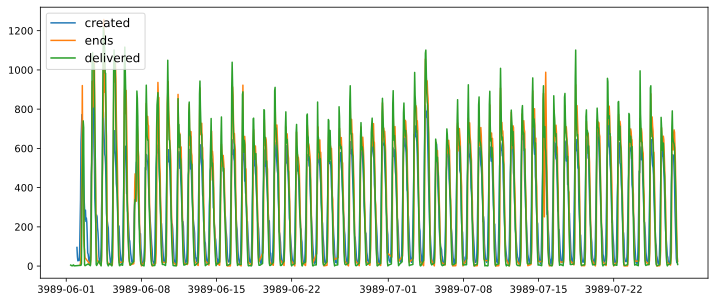

In [16]:
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(111)
ax1.plot(df_created['created_hour'], df_created['created_cnt'], label='created')
ax1.plot(df_window_ends['window_ends_hour'], df_window_ends['window_ends_cnt'], label='ends')
ax1.plot(df_delivered['delivered_hour'], df_delivered['delivered_cnt'], label='delivered')
ax1.legend(loc='upper left', fontsize=12)
plt.show()

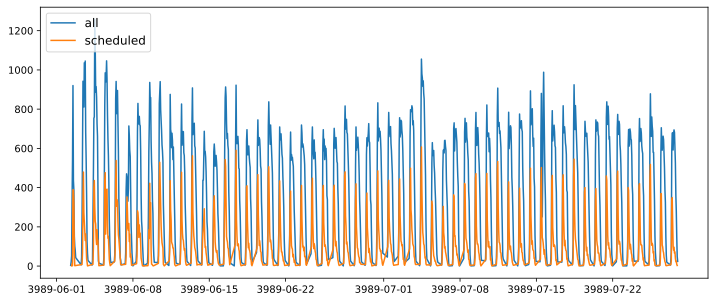

In [17]:
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(111)
ax1.plot(df_window_ends['window_ends_hour'], df_window_ends['window_ends_cnt'], label='all')
ax1.plot(df_scheduled['window_ends_hour'], df_scheduled['scheduled_cnt'], label='scheduled')
ax1.legend(loc='upper left', fontsize=12)
plt.show()

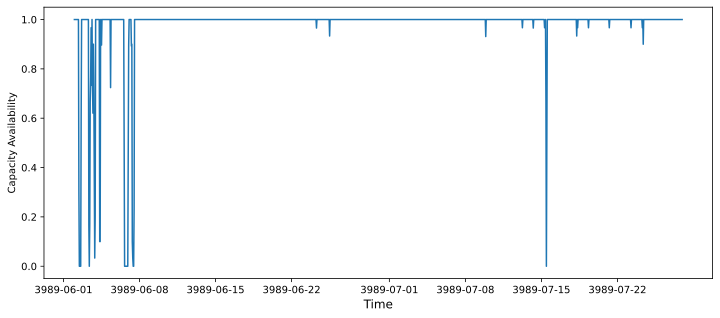

In [18]:
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(111)
ax1.plot(df_cpcty_created['created_hour'], df_cpcty_created['availability'])
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('Capacity Availability')
plt.show()

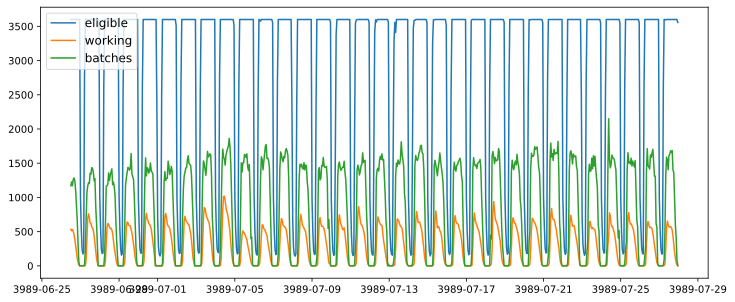

In [19]:
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(111)
ax1.plot(df_shppr_created['created_hour'], df_shppr_created['eligible_shoppers'], label='eligible')
ax1.plot(df_shppr_created['created_hour'], df_shppr_created['working_shoppers'], label='working')
ax1.plot(df_shppr_created['created_hour'], df_shppr_created['shoppers_having_batches'], label='batches')
ax1.legend(loc='upper left', fontsize=12)
plt.show()

In [20]:
# Production Code
# Merge

data = df_window_ends.merge(df_scheduled, 
                           left_on=['window_ends_hour'],
                           right_on=['window_ends_hour'],
                           how='left')

data = data.merge(df_created, 
                   left_on=['window_ends_hour'],
                   right_on=['created_hour'],
                   how='left')

data = data.merge(df_delivered,
                 left_on=['window_ends_hour'],
                 right_on=['delivered_hour'],
                 how='left')

data = data.merge(df_cpcty_created,
                 left_on=['window_ends_hour'],
                 right_on=['created_hour'],
                 how='left')

data = data.merge(df_shppr_created[['created_hour', 'eligible_shoppers', 'working_pct', 'coverage_pct']],
                 left_on=['window_ends_hour'],
                 right_on=['created_hour'],
                 how='left')

data = data.merge(df_lost[['created_hour', 'ld_percent']],
                 left_on=['window_ends_hour'],
                 right_on=['created_hour'],
                 how='left')

data.fillna(value={'created_cnt':0, 'delivered_cnt':0, 'scheduled_cnt':0,
                   'availability':0, 
                  'eligible_shoppers':0, 'working_pct':0, 'coverage_pct':0}, 
           inplace=True)

data_BAK = data.copy()
data = data[['window_ends_hour', 'window_ends_cnt', 'created_cnt', 'delivered_cnt', 'scheduled_cnt',
             'availability', 'ld_percent', 'eligible_shoppers', 'working_pct', 'coverage_pct']]
data.rename(columns={'window_ends_hour':'time'}, inplace=True)

In [21]:
data_BAK.tail(5)

,window_ends_hour,window_ends_cnt,scheduled_cnt,created_hour_x,created_cnt,delivered_hour,delivered_cnt,created_hour_y,availability,created_hour_add1wk,availability_lag1wk,created_hour_x,eligible_shoppers,working_pct,coverage_pct,created_hour_y,ld_percent
937,2020-07-26 19:00:00,362,22.0,2020-07-26 19:00:00,125.0,2020-07-26 19:00:00,351.0,2020-07-26 19:00:00,1.0,2020-07-26 19:00:00,1.0,2020-07-26 19:00:00,3600.000000,0.057394,0.269398,2020-07-26 19:00:00,0.001501
938,2020-07-26 20:00:00,279,26.0,2020-07-26 20:00:00,39.0,2020-07-26 20:00:00,184.0,2020-07-26 20:00:00,1.0,2020-07-26 20:00:00,1.0,2020-07-26 20:00:00,3600.000000,0.031073,0.165734,2020-07-26 20:00:00,0.001349
939,2020-07-26 21:00:00,148,9.0,2020-07-26 21:00:00,19.0,2020-07-26 21:00:00,100.0,2020-07-26 21:00:00,1.0,2020-07-26 21:00:00,1.0,2020-07-26 21:00:00,3600.000000,0.013515,0.111657,2020-07-26 21:00:00,0.001292
940,2020-07-26 22:00:00,49,3.0,NaT,NaN,2020-07-26 22:00:00,21.0,2020-07-26 22:00:00,1.0,2020-07-26 22:00:00,1.0,2020-07-26 22:00:00,3600.000000,0.004312,0.022441,2020-07-26 22:00:00,0.001470
941,2020-07-26 23:00:00,24,NaN,NaT,NaN,2020-07-26 23:00:00,8.0,2020-07-26 23:00:00,1.0,2020-07-26 23:00:00,1.0,2020-07-26 23:00:00,3556.666667,0.001228,0.000375,2020-07-26 23:00:00,0.000982


In [22]:
data.isnull().sum()

time                   0
window_ends_cnt        0
created_cnt            2
delivered_cnt         13
scheduled_cnt        135
availability           0
ld_percent             0
eligible_shoppers    406
working_pct          406
coverage_pct         406
dtype: int64

In [23]:
# Production Code

data['gap'] = data['window_ends_cnt'] * (1 + data['ld_percent']) - data['delivered_cnt']

data['weekday'] = data['time'].map(lambda x: x.weekday())
data['hour'] = data['time'].map(lambda x: x.hour)

# Prepare lag data
# Run at 10:30AM(10AM), Lag 1hr is 9AM(9-10AM), Lag 2 hr is 8AM(8-9AM).
data['time_add1hr'] = data['time'].map(lambda x: x + timedelta(hours=1))
data['time_add2hr'] = data['time'].map(lambda x: x + timedelta(hours=2))

# Adding lag feature and create label
# Lag 1 hour
df_lag1 = data[['time_add1hr', 'window_ends_cnt', 'created_cnt',
                'availability',
               'eligible_shoppers', 'working_pct', 'coverage_pct']].copy()
col_rename_t1 = {_s:_s + '_lag1' for _s in ['window_ends_cnt', 'created_cnt',
               'availability',
               'eligible_shoppers', 'working_pct', 'coverage_pct']}
df_lag1.rename(columns=col_rename_t1, inplace=True)

# Lag 2 hour
df_lag2 = data[['time_add2hr', 'window_ends_cnt', 'created_cnt',
                'availability',
               'eligible_shoppers', 'working_pct', 'coverage_pct']].copy()
col_rename_t2 = {_s:_s + '_lag2' for _s in ['window_ends_cnt', 'created_cnt',
               'availability',
               'eligible_shoppers', 'working_pct', 'coverage_pct']}
df_lag2.rename(columns=col_rename_t2, inplace=True)

# Training Label and Naive Forecast
# Run at 10:30AM(10AM), predict 2hr leading time is 1PM.
# Naive forecast is yesterday's 1-2PM.
data['time_sub3hr'] = data['time'].map(lambda x: x - timedelta(hours=3))
data['time_add1dy'] = data['time'].map(lambda x: x + timedelta(hours=21))

# Lag 1 Day
df_lag3 = data[['time_add1dy', 'gap']].copy()
col_rename_t3 = {'gap':'gap_forecast_naive'}
df_lag3.rename(columns=col_rename_t3, inplace=True)

# Training Label
# Scheduled feature is the number of scheduled orders for the prediction hour
df_lead3 = data[['time_sub3hr', 'gap', 'scheduled_cnt']].copy()
df_lead3.rename(columns={'gap':'gap_forecast_label',
                        'scheduled_cnt': 'scheduled_feature'}, inplace=True)

# Merge DataFrame
data = data[['time', 'hour', 'weekday',
             'window_ends_cnt', 'created_cnt', 'delivered_cnt', 'scheduled_cnt',
             'availability', 
             'eligible_shoppers', 'working_pct', 'coverage_pct', 
             'gap']].merge(df_lag1, 
                  left_on='time',
                  right_on='time_add1hr',
                  how='left')
data = data.merge(df_lag2, 
                  left_on='time',
                  right_on='time_add2hr',
                  how='left')
data = data.merge(df_lead3, 
                  left_on='time',
                  right_on='time_sub3hr',
                  how='left')
data = data.merge(df_lag3, 
                  left_on='time',
                  right_on='time_add1dy',
                  how='left')

# Dummy variables for hour and weekday
data = data.join(pd.get_dummies(data['hour'], prefix='hour'))
data = data.join(pd.get_dummies(data['weekday'], prefix='weekday'))

In [24]:
len(data[data['gap'] > 0])

572

In [25]:
len(data[data['gap'] <= 0])

357

In [26]:
len(data)

942

In [27]:
data.tail(5)

,time,hour,weekday,window_ends_cnt,created_cnt,delivered_cnt,scheduled_cnt,availability,eligible_shoppers,working_pct,...,hour_21,hour_22,hour_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
937,2020-07-26 19:00:00,19,6,362,125.0,351.0,22.0,1.0,3600.000000,0.057394,...,0,0,0,0,0,0,0,0,0,1
938,2020-07-26 20:00:00,20,6,279,39.0,184.0,26.0,1.0,3600.000000,0.031073,...,0,0,0,0,0,0,0,0,0,1
939,2020-07-26 21:00:00,21,6,148,19.0,100.0,9.0,1.0,3600.000000,0.013515,...,1,0,0,0,0,0,0,0,0,1
940,2020-07-26 22:00:00,22,6,49,NaN,21.0,3.0,1.0,3600.000000,0.004312,...,0,1,0,0,0,0,0,0,0,1
941,2020-07-26 23:00:00,23,6,24,NaN,8.0,NaN,1.0,3556.666667,0.001228,...,0,0,1,0,0,0,0,0,0,1


In [28]:
df_lag1.tail(5)

,time_add1hr,window_ends_cnt_lag1,created_cnt_lag1,availability_lag1,eligible_shoppers_lag1,working_pct_lag1,coverage_pct_lag1
937,2020-07-26 20:00:00,362,125.0,1.0,3600.000000,0.057394,0.269398
938,2020-07-26 21:00:00,279,39.0,1.0,3600.000000,0.031073,0.165734
939,2020-07-26 22:00:00,148,19.0,1.0,3600.000000,0.013515,0.111657
940,2020-07-26 23:00:00,49,NaN,1.0,3600.000000,0.004312,0.022441
941,2020-07-27 00:00:00,24,NaN,1.0,3556.666667,0.001228,0.000375


In [29]:
df_lag2.tail(5)

,time_add2hr,window_ends_cnt_lag2,created_cnt_lag2,availability_lag2,eligible_shoppers_lag2,working_pct_lag2,coverage_pct_lag2
937,2020-07-26 21:00:00,362,125.0,1.0,3600.000000,0.057394,0.269398
938,2020-07-26 22:00:00,279,39.0,1.0,3600.000000,0.031073,0.165734
939,2020-07-26 23:00:00,148,19.0,1.0,3600.000000,0.013515,0.111657
940,2020-07-27 00:00:00,49,NaN,1.0,3600.000000,0.004312,0.022441
941,2020-07-27 01:00:00,24,NaN,1.0,3556.666667,0.001228,0.000375


In [30]:
# Production Code
# Prepared for training

cols = ['time', 'window_ends_cnt', 'created_cnt', 'delivered_cnt', 'scheduled_cnt',
        'availability', 
        'eligible_shoppers', 'working_pct', 'coverage_pct', 'gap']
hours_6_23 = ['hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 
              'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 
              'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 
              'hour_21', 'hour_22', 'hour_23']
col_hours = [_ for _ in data.columns.tolist() if _ in hours_6_23]
features = col_hours + ['weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 
            'weekday_4', 'weekday_5', 'weekday_6', 
            'scheduled_feature',
            'window_ends_cnt_lag1', 'created_cnt_lag1',
            'availability_lag1', 
            'eligible_shoppers_lag1', 'working_pct_lag1', 'coverage_pct_lag1', 
            'window_ends_cnt_lag2', 'created_cnt_lag2',
            'availability_lag2', 
            'eligible_shoppers_lag2', 'working_pct_lag2', 'coverage_pct_lag2']
label = ['gap_forecast_label', 'gap_forecast_naive']

data = data[cols + features + label]

In [31]:
# Production Code
# Hypoparameter training

# Reset index, otherwise there is problem with my own CViterator
# Get 7 weeks of data
data = data[data['time'] >= end_dt - timedelta(days=days - 7)]
data.reset_index(drop=True, inplace=True)
data.fillna(0, inplace=True)

myCViterator = []
for time_filter in [end_dt - timedelta(days=21), end_dt - timedelta(days=14)]:
    trainIndices = data[data.time < time_filter].index.values.astype(int)
    testIndices =  data[(data.time >= time_filter) & 
                        (data.time < time_filter + timedelta(days=7))].index.values.astype(int)
    myCViterator.append( (trainIndices, testIndices) )

In [32]:
# Production Code
# Model Training
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV

train_data = data[data['time'] < end_dt - timedelta(days=7)][features]
train_label = data[data['time'] < end_dt - timedelta(days=7)]['gap_forecast_label']

test_data = data[data['time'] >= end_dt - timedelta(days=7)][features]
test_label = data[data['time'] >= end_dt - timedelta(days=7)]['gap_forecast_label']

# Define Model Parameters      
grid = RidgeCV(alphas=[0.001,0.01, 0.1, 1, 10, 100], cv=myCViterator)

grid.fit(train_data, train_label)

print({_k:round(_v, 4) for _k, _v in zip(features, grid.coef_)})
print(grid.alpha_)

{'hour_6': 0.0, 'hour_7': -261.7001, 'hour_8': -214.6623, 'hour_9': -99.3907, 'hour_10': -20.543, 'hour_11': 14.9559, 'hour_12': 34.261, 'hour_13': 14.6769, 'hour_14': 36.4186, 'hour_15': 67.9108, 'hour_16': 50.5593, 'hour_17': 88.7807, 'hour_18': 36.9945, 'hour_19': 16.1325, 'hour_20': 4.7867, 'hour_21': -3.697, 'hour_22': -1.7262, 'hour_23': -0.0494, 'weekday_0': -1.0419, 'weekday_1': 0.8873, 'weekday_2': 3.224, 'weekday_3': -2.5292, 'weekday_4': -6.5081, 'weekday_5': 4.4085, 'weekday_6': 1.5594, 'scheduled_feature': 0.2555, 'window_ends_cnt_lag1': -0.032, 'created_cnt_lag1': -0.0843, 'availability_lag1': 9.417, 'eligible_shoppers_lag1': 0.0054, 'working_pct_lag1': -93.9288, 'coverage_pct_lag1': -55.5203, 'window_ends_cnt_lag2': 0.0305, 'created_cnt_lag2': 0.1754, 'availability_lag2': -65.0493, 'eligible_shoppers_lag2': -0.0029, 'working_pct_lag2': 250.7801, 'coverage_pct_lag2': -46.6406}
0.01


In [33]:
# Production Code
# XGBoost Regression

from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

xgb = XGBRegressor(n_jobs=-1, silent=1, subsample=0.9, eval_metric='rmse')

params_random = {
        "max_depth" : [2, 3, 4, 5, 6, 7, 8, 9],
        "n_estimators": [20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140],
        "min_child_weight": [1, 2, 3, 4, 5, 6],
        "gamma": [i/10.0 for i in range(3,6)]
         }

model = RandomizedSearchCV(estimator=xgb, param_distributions=params_random, cv=myCViterator)

model.fit(train_data, train_label)
print(model.best_params_)

{'n_estimators': 20, 'min_child_weight': 2, 'max_depth': 3, 'gamma': 0.4}


In [34]:
# Production Code

# Check Model Performance
df_forecast = data[data['time'] >= end_dt - timedelta(days=7)][['time', 'gap_forecast_label', 'gap_forecast_naive']]
df_forecast['gap_forecast_linear'] = grid.predict(test_data)
df_forecast['gap_forecast_xgb'] = model.best_estimator_.predict(test_data)
df_forecast['naive_residual'] = df_forecast['gap_forecast_naive'] - df_forecast['gap_forecast_label']
df_forecast['linear_residual'] = df_forecast['gap_forecast_linear'] - df_forecast['gap_forecast_label']
df_forecast['xgb_residual'] = df_forecast['gap_forecast_xgb'] - df_forecast['gap_forecast_label']

# Join Features
df_forecast = df_forecast.join(test_data)

# Measure accuray whether needs scaling
df_forecast['gap_forecast_label_tf'] = df_forecast['gap_forecast_label'].map(lambda x: 1 if x > 0 else
                                                                                    -1 if x < 0 else
                                                                                     0)
df_forecast['gap_forecast_naive_tf'] = df_forecast['gap_forecast_naive'].map(lambda x: 1 if x > 0 else
                                                                                    -1 if x < 0 else
                                                                                     0)
df_forecast['gap_forecast_linear_tf'] = df_forecast['gap_forecast_linear'].map(lambda x: 1 if x > 0 else
                                                                                    -1 if x < 0 else
                                                                                     0)
df_forecast['gap_forecast_xgb_tf'] = df_forecast['gap_forecast_xgb'].map(lambda x: 1 if x > 0 else
                                                                                    -1 if x < 0 else
                                                                                     0)

df_forecast.replace({'gap_forecast_label_tf':{0: np.nan},
                    'gap_forecast_naive_tf':{0: np.nan},
                    'gap_forecast_linear_tf':{0: np.nan},
                    'gap_forecast_xgb_tf':{0: np.nan}},
                   inplace=True)

# Under supply residual 
df_forecast['naive_residual_label'] = abs(df_forecast['naive_residual']) * df_forecast['gap_forecast_label_tf']
df_forecast['linear_residual_label'] = abs(df_forecast['linear_residual']) * df_forecast['gap_forecast_label_tf']
df_forecast['xgb_residual_label'] = abs(df_forecast['xgb_residual']) * df_forecast['gap_forecast_label_tf']

# Accuracy Score
from sklearn.metrics import accuracy_score
df_tf = df_forecast[['gap_forecast_label_tf', 'gap_forecast_naive_tf',
                    'gap_forecast_linear_tf', 'gap_forecast_xgb_tf']].copy()
df_tf.dropna(inplace=True, axis=0)
print("Naive model accuracy:")
print(round(accuracy_score(df_tf['gap_forecast_label_tf'], df_tf['gap_forecast_naive_tf']), 3))

print("\nLinear model accuracy:")
print(round(accuracy_score(df_tf['gap_forecast_label_tf'], df_tf['gap_forecast_linear_tf']), 3))

print("\nXGB model accuracy:")
print(round(accuracy_score(df_tf['gap_forecast_label_tf'], df_tf['gap_forecast_xgb_tf']), 3))

Naive model accuracy:
0.896

Linear model accuracy:
0.948

XGB model accuracy:
0.948


In [35]:
# Production Code

# APE
df_forecast['naive_ape'] = ((df_forecast['gap_forecast_naive'] - df_forecast['gap_forecast_label']) / 
                             df_forecast['gap_forecast_label'])
df_forecast['naive_ape'] = df_forecast['naive_ape'].map(lambda x: abs(x) if x not in [-np.inf, np.inf] else 
                                                        0 if math.isnan(x) else 0)

df_forecast['linear_ape'] = ((df_forecast['gap_forecast_linear'] - df_forecast['gap_forecast_label']) / 
                             df_forecast['gap_forecast_label'])
df_forecast['linear_ape'] = df_forecast['linear_ape'].map(lambda x: abs(x) if x not in [-np.inf, np.inf] else 
                                                        0 if math.isnan(x) else 0)

df_forecast['xgb_ape'] = ((df_forecast['gap_forecast_xgb'] - df_forecast['gap_forecast_label']) / 
                             df_forecast['gap_forecast_label'])
df_forecast['xgb_ape'] = df_forecast['xgb_ape'].map(lambda x: abs(x) if x not in [-np.inf, np.inf] else 
                                                        0 if math.isnan(x) else 0)

# Fill NA
df_forecast.fillna(value={'naive_ape':0, 'linearr_ape':0, 'xgb_ape':0}, inplace=True)

# Calculate Weight
df_forecast['gap_forecast_label_abs'] = df_forecast['gap_forecast_label'].map(lambda x: abs(x))
tot_gap = sum(df_forecast['gap_forecast_label_abs'])
df_forecast['weight'] = df_forecast['gap_forecast_label_abs'] * 1.0 / tot_gap

# Weighted APE
df_forecast['naive_wape'] = df_forecast['naive_ape'] * df_forecast['weight']
df_forecast['linear_wape'] = df_forecast['linear_ape'] * df_forecast['weight']
df_forecast['xgb_wape'] = df_forecast['xgb_ape'] * df_forecast['weight']

# Print
print('Model MAPE:')
df_forecast[['naive_wape', 'linear_wape',
             'xgb_wape']].sum().reset_index()

Model MAPE:


,index,0
0,naive_wape,0.542311
1,linear_wape,0.397277
2,xgb_wape,0.405834


In [36]:
df_forecast[['gap_forecast_label', 
             'gap_forecast_naive', 'gap_forecast_linear', 'gap_forecast_xgb', 
             'weight',
            'naive_ape', 'linear_ape', 'xgb_ape']].head(10)

,gap_forecast_label,gap_forecast_naive,gap_forecast_linear,gap_forecast_xgb,weight,naive_ape,linear_ape,xgb_ape
711,-199.002128,-136.065771,-117.082286,-136.846573,0.030477,0.316260,0.411653,0.312336
712,-102.055301,-58.996810,-67.227328,-62.905296,0.015630,0.421913,0.341266,0.383616
713,-25.131452,-66.045774,-79.967076,-85.737846,0.003849,1.628013,2.181952,2.411575
714,-29.143264,-10.046169,-32.546011,-37.904121,0.004463,0.655283,0.116759,0.300613
715,49.988735,30.129436,29.901463,83.163094,0.007656,0.397275,0.401836,0.663637
716,91.711047,63.969085,81.769858,69.540405,0.014046,0.302493,0.108397,0.241745
717,-27.065904,53.668869,60.226328,83.646530,0.004145,2.982896,3.225173,4.090476
718,88.002261,111.141508,91.712832,70.399391,0.013478,0.262939,0.042164,0.200027
719,132.612199,57.841238,114.943659,86.481369,0.020310,0.563832,0.133235,0.347863
720,115.594058,43.581644,82.937108,81.315010,0.017703,0.622977,0.282514,0.296547


In [37]:
# Production Code
# Correlation

print('Correlation Naive:')
print(df_forecast[['gap_forecast_label', 'gap_forecast_naive']].corr().iloc[0]['gap_forecast_naive'])

print('\nCorrelation linear:')
print(df_forecast[['gap_forecast_label', 'gap_forecast_linear']].corr().iloc[0]['gap_forecast_linear'])

print('\nCorrelation xgb:')
print(df_forecast[['gap_forecast_label', 'gap_forecast_xgb']].corr().iloc[0]['gap_forecast_xgb'])

Correlation Naive:
0.7444395873833018

Correlation linear:
0.87354185277121

Correlation xgb:
0.8753450858472417


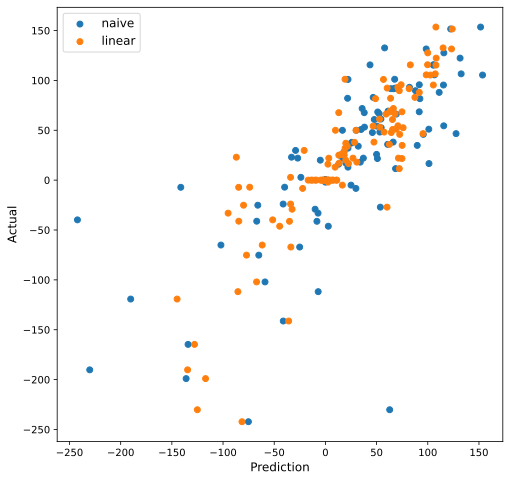

In [38]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(111)
ax1.scatter(df_forecast['gap_forecast_naive'], df_forecast['gap_forecast_label'], label='naive')
ax1.scatter(df_forecast['gap_forecast_linear'], df_forecast['gap_forecast_label'], label='linear')
ax1.legend(loc='upper left', fontsize=12)
ax1.set_xlabel('Prediction', fontsize=12)
ax1.set_ylabel('Actual', fontsize=12)
plt.show()

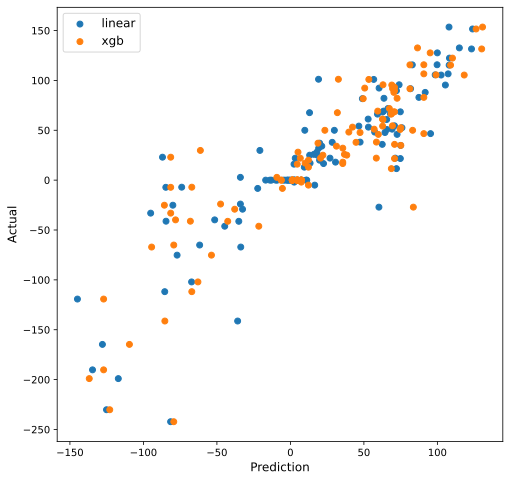

In [39]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(111)
ax1.scatter(df_forecast['gap_forecast_linear'], df_forecast['gap_forecast_label'], label='linear')
ax1.scatter(df_forecast['gap_forecast_xgb'], df_forecast['gap_forecast_label'], label='xgb')
ax1.legend(loc='upper left', fontsize=12)
ax1.set_xlabel('Prediction', fontsize=12)
ax1.set_ylabel('Actual', fontsize=12)
plt.show()

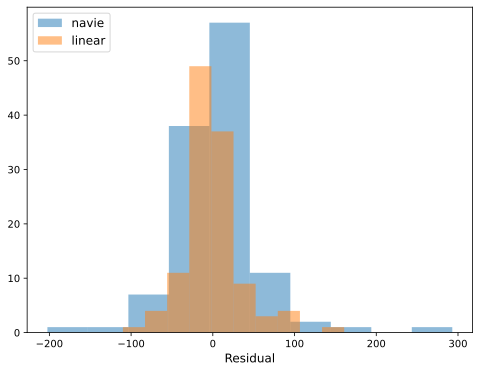

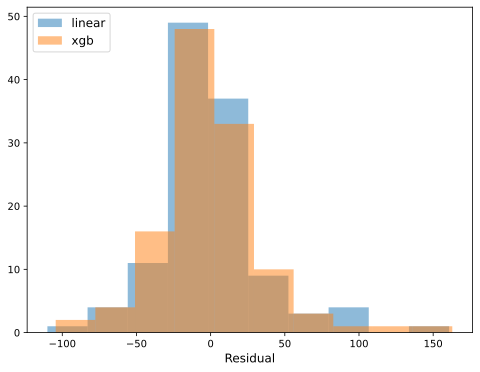

In [40]:
# View Resiude Histogram
if True:
    fig = plt.figure(figsize=(8, 6))
    ax1 = fig.add_subplot(111)
    ax1.hist(df_forecast['naive_residual'], label='navie', alpha=0.5)
    ax1.hist(df_forecast['linear_residual'], label='linear', alpha=0.5)
    ax1.legend(loc='upper left', fontsize=12)
    ax1.set_xlabel('Residual', fontsize=12)
    plt.show()
    
if True:
    fig = plt.figure(figsize=(8, 6))
    ax1 = fig.add_subplot(111)
    ax1.hist(df_forecast['linear_residual'], label='linear', alpha=0.5)
    ax1.hist(df_forecast['xgb_residual'], label='xgb', alpha=0.5)
    ax1.legend(loc='upper left', fontsize=12)
    ax1.set_xlabel('Residual', fontsize=12)
    plt.show()

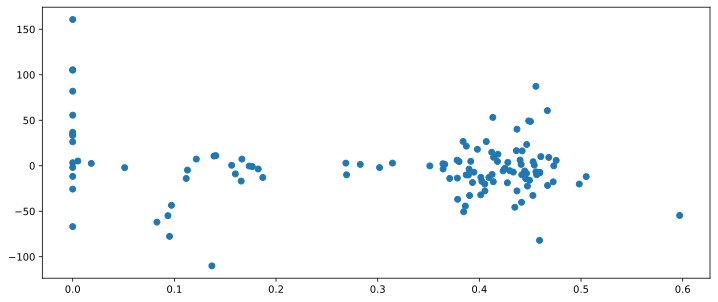

In [41]:
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(111)
ax1.scatter(df_forecast['coverage_pct_lag2'], df_forecast['linear_residual'])
plt.show()

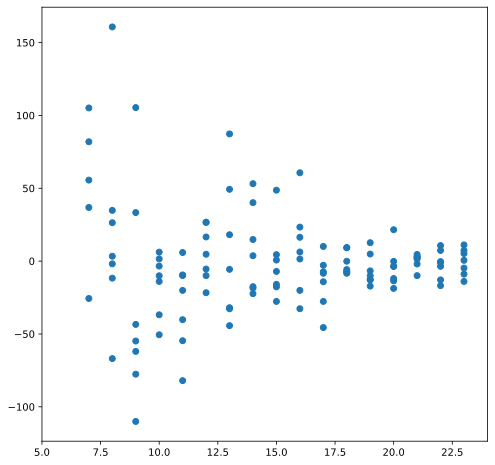

In [42]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(111)
ax1.scatter(df_forecast['time'].map(lambda x: x.hour), df_forecast['linear_residual'])
ax1.set_xlim([5, 24])
plt.show()

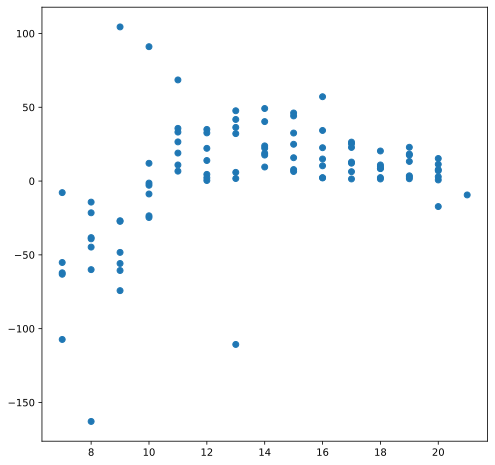

In [43]:
# Negative is corresponding to gap_forecast_label is negative
# Negative forecast has larger residuals, which is not a concern compared to positive forecast.

fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(111)
ax1.scatter(df_forecast['time'].map(lambda x: x.hour), df_forecast['xgb_residual_label'])
plt.show()

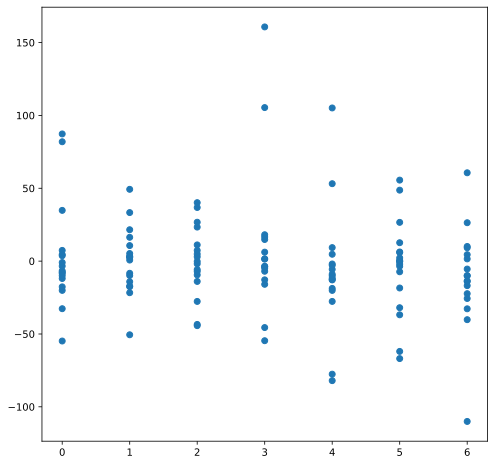

In [44]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(111)
ax1.scatter(df_forecast['time'].map(lambda x: x.weekday()), df_forecast['linear_residual'])
plt.show()